In [1]:
import pandas as pd

In [2]:
filepath = r"E:\Data\S&P500"
filename = r"\Yahoo_S&P500_2004-2019.csv"

In [3]:
df = pd.read_csv(filepath+filename)
df["date"] = pd.to_datetime(df["Date"])
df = df.set_index('date')

In [4]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])

# Import the backtrader platform
import backtrader as bt

In [5]:
def graph(data):
    date = []
    close = []
    open_ = []
    high = []
    low = []

    for i in range(90):
        date.append(data.datetime.date(-i))
        open_.append(data.open[-i])
        close.append(data.close[-i])
        high.append(data.low[-i])
        low.append(data.high[-i])  
        
    df = pd.DataFrame()
    df['date'] = date
    df['date'] = pd.to_datetime(df['date'])
    df['close'] = close
    df['open'] = open_
    df['high'] = high
    df['low'] = low
    
    #reversing dataframe
    df = df[::-1]
    
    createAndSavePlot(df)

In [6]:
from math import pi
import pandas as pd
from bokeh.plotting import figure, show, output_file
from bokeh.io import export_png

def createAndSavePlot(df, plot_height=100,plot_width=200):
    inc = df.close > df.open
    dec = df.open > df.close
    w = 12*60*60*1000 # half day in ms

    #TOOLS = "pan,wheel_zoom,box_zoom,reset,save"

    p = figure(x_axis_type="datetime", plot_height=100,plot_width=200)
    #p.xaxis.major_label_orientation = pi/4
    #p.grid.grid_line_alpha=0.3

    p.segment(df.date, df.high, df.date, df.low, color="black")
    p.vbar(df.date[inc], w, df.open[inc], df.close[inc], fill_color="#D5E1DD", line_color="black")
    p.vbar(df.date[dec], w, df.open[dec], df.close[dec], fill_color="#F2583E", line_color="black")

    p.toolbar.logo = None
    p.toolbar_location = None

    p.xaxis.major_tick_line_color = None  # turn off x-axis major ticks
    p.xaxis.minor_tick_line_color = None  # turn off x-axis minor ticks
    p.yaxis.major_tick_line_color = None  # turn off y-axis major ticks
    p.yaxis.minor_tick_line_color = None  # turn off y-axis minor ticks
    p.xaxis.major_label_text_color = None  #note that this leaves space between the axis and the axis label  
    p.yaxis.major_label_text_color = None  #note that this leaves space between the axis and the axis label

    export_png(p, filename="backtest.png")

In [7]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
from PIL import Image
import os

In [8]:
class TestStrategy(bt.Strategy):
    params = (
        ('exitbars', 5),
    )

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
        self.model = keras.models.load_model("model1.h5")
        
        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.sellprice = None
        self.buycomm = None
        self.none = 0

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

                self.sellprice = order.executed.price
            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        # Simply log the closing price of the series from the reference
        #self.log('Data, {}'.format(self.datas[0].datetime.date(0)))
        self.log('Close, %.2f' % self.dataclose[0])
        online = True
        if(online):
            graph(self.data)
        else:
            #Need to use the already created graphs if i want it to run fast
            a = 1
        img = np.array(
            Image.open(
                os.path.join(r"C:\Users\ken\Desktop\OneDrive\OneDrive - Knights - University of Central Florida\UCF Spring 2019\Machine Learning\signal",
                             r"backtest.png"))).reshape(1,100,200,4)
        img = img/255
        pred = self.model.predict(img).argmax(axis=1)[0]
        
        if(pred == 2):
            self.log('BUY CREATE, %.2f' % self.dataclose[0])
            self.order = self.buy()
        if(pred == 0):
            self.log('SELL CREATE, %.2f' % self.dataclose[0])
            self.order = self.sell()
        if(pred == 1):
            if(self.position.size > 0 and self.buyprice * .01 < self.dataclose[0] - self.buyprice):
                self.log('Take profit, %.2f' % self.dataclose[0])
                for i in range(self.position.size):
                    self.order = self.sell()
            elif(self.position.size < 0 and self.sellprice * .01 < self.sellprice - self.dataclose[0]):
                self.log('Take profit, %.2f' % self.dataclose[0])
                for i in range(self.position.size):
                    self.order = self.buy()
                
        self.log('Current Position size: {}'.format(self.position.size))



In [9]:

# Create a cerebro entity
cerebro = bt.Cerebro()

cerebro.addstrategy(TestStrategy)

# Create a Data Feed
data = bt.feeds.YahooFinanceCSVData(
        dataname=filepath+filename,
        # Do not pass values before this date
        fromdate=datetime.datetime(2009, 1, 1),
        # Do not pass values after this date
        todate=datetime.datetime(2009, 12, 31),
        reverse=False)

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(20000.0)

# Add a fixedsize sizer according to the stake
cerebro.addsizer(bt.sizers.FixedSize, stake=1)

# Set the commission - 0.1% ... divide by 100 to remove the %
cerebro.broker.setcommission(commission=0.001)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 20000.00
2009-01-02, Close, 931.80
2009-01-02, Current Position size: 0
2009-01-05, Close, 927.45
2009-01-05, Current Position size: 0
2009-01-06, Close, 934.70
2009-01-06, Current Position size: 0
2009-01-07, Close, 906.65
2009-01-07, Current Position size: 0
2009-01-08, Close, 909.73
2009-01-08, Current Position size: 0
2009-01-09, Close, 890.35
2009-01-09, Current Position size: 0
2009-01-12, Close, 870.26
2009-01-12, Current Position size: 0
2009-01-13, Close, 871.79
2009-01-13, Current Position size: 0
2009-01-14, Close, 842.62
2009-01-14, BUY CREATE, 842.62
2009-01-14, Current Position size: 0
2009-01-15, BUY EXECUTED, Price: 841.99, Cost: 841.99, Comm 0.84
2009-01-15, Close, 843.74
2009-01-15, BUY CREATE, 843.74
2009-01-15, Current Position size: 1
2009-01-16, BUY EXECUTED, Price: 844.45, Cost: 844.45, Comm 0.84
2009-01-16, Close, 850.12
2009-01-16, Current Position size: 2
2009-01-20, Close, 805.22
2009-01-20, Current Position size: 2
2009-01-21, Close

2009-04-20, Current Position size: 0
2009-04-21, Close, 850.08
2009-04-21, Current Position size: 0
2009-04-22, Close, 843.55
2009-04-22, Current Position size: 0
2009-04-23, Close, 851.92
2009-04-23, Current Position size: 0
2009-04-24, Close, 866.23
2009-04-24, Current Position size: 0
2009-04-27, Close, 857.51
2009-04-27, Current Position size: 0
2009-04-28, Close, 855.16
2009-04-28, Current Position size: 0
2009-04-29, Close, 873.64
2009-04-29, Current Position size: 0
2009-04-30, Close, 872.81
2009-04-30, Current Position size: 0
2009-05-01, Close, 877.52
2009-05-01, Current Position size: 0
2009-05-04, Close, 907.24
2009-05-04, Current Position size: 0
2009-05-05, Close, 903.80
2009-05-05, Current Position size: 0
2009-05-06, Close, 919.53
2009-05-06, Current Position size: 0
2009-05-07, Close, 907.39
2009-05-07, Current Position size: 0
2009-05-08, Close, 929.23
2009-05-08, Current Position size: 0
2009-05-11, Close, 909.24
2009-05-11, Current Position size: 0
2009-05-12, Close,

2009-09-11, Current Position size: -1
2009-09-14, Close, 1049.34
2009-09-14, Current Position size: -1
2009-09-15, Close, 1052.63
2009-09-15, Current Position size: -1
2009-09-16, Close, 1068.76
2009-09-16, Current Position size: -1
2009-09-17, Close, 1065.49
2009-09-17, Current Position size: -1
2009-09-18, Close, 1068.30
2009-09-18, Current Position size: -1
2009-09-21, Close, 1064.66
2009-09-21, Current Position size: -1
2009-09-22, Close, 1071.66
2009-09-22, Current Position size: -1
2009-09-23, Close, 1060.87
2009-09-23, Current Position size: -1
2009-09-24, Close, 1050.78
2009-09-24, Current Position size: -1
2009-09-25, Close, 1044.38
2009-09-25, Current Position size: -1
2009-09-28, Close, 1062.98
2009-09-28, Current Position size: -1
2009-09-29, Close, 1060.61
2009-09-29, Current Position size: -1
2009-09-30, Close, 1057.08
2009-09-30, Current Position size: -1
2009-10-01, Close, 1029.85
2009-10-01, Current Position size: -1
2009-10-02, Close, 1025.21
2009-10-02, Current Posit

<IPython.core.display.Javascript object>


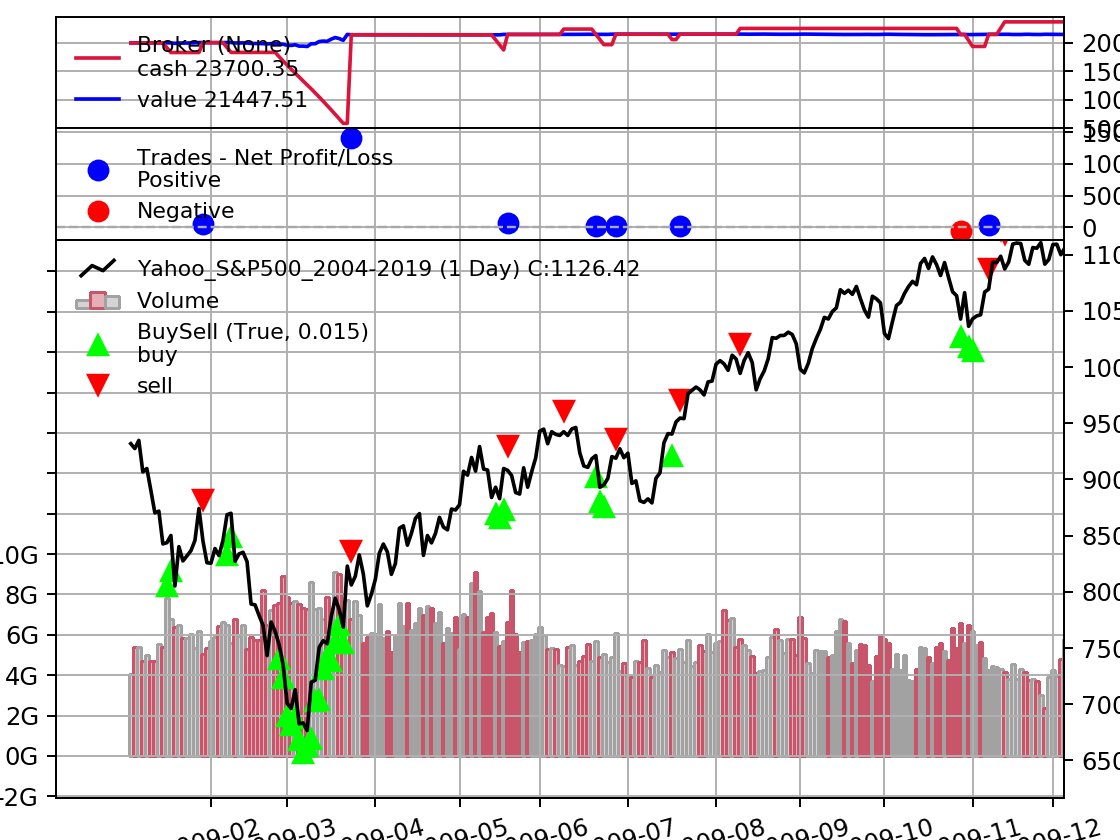

[[<Figure size 640x480 with 4 Axes>]]

In [10]:
cerebro.plot()

Promising result but this was a bull season. We also need to do more backtesting